# Project 1: Image and Video Classification,
# Part I - Video Classification (50 points)


 - **Student Name**:  Tomas David Medina Romero

 - **Finish Date**: 

Points Distribution: 
- Task1: 0
- Task2: 15
- Task3: 20
- Task4: 15

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from IPython.display import YouTubeVideo
import pickle as pk
import urllib
import pandas as pd
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torchsummary import summary
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

## Task 0: Getting Started

Read the getting started guide titled **"Python for Deep Learning"** and get familiar with Python and PyTorch. Read the provided code below and get familiar with the commands and their parameters to understand what the code is trying to do. We recommend to spend a fair amount of time to understand all the different parts of the code. This understanding will be important for this and future projects.


This Project consist of 2 parts:

    Part I - Video Classification (50 points)    
    Part II - Image Classification (50 points) 
    
Even though image classification might seem as an easier task, we will work with **pre-extracted** features in Part I, and in Part II you will have experience with an **end-to-end training**.   
In this part we will perform a simple Logistic Regression to predict a video class. We will use YouTube-8M, large-scale labeled video dataset (https://research.google.com/youtube8m/index.html). 

Now please **follow the tasks and fill in the blanks**.

## Task 1:  Dataset and Data Loading (0 points)
Look through the **Dataset** and **DataLoader** below which we will use to load training and testing images of the YouTube-8M dataset provided. 

In [2]:
feat_dim = 1024 # for RGB features 
nb_classes = 3862 

class YT8MminiDataset(Dataset):

    def __init__(self, pk_file, root_dir):
        """
        Args:
            pk_file (dict): video id with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        with open(pk_file, 'rb') as f:
            self.video_record = pk.load(f)
        self.vids = sorted(list(self.video_record.keys()))
        self.root_dir = root_dir

    def __len__(self):
        return len(self.vids)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        vid = self.vids[idx]
        #We will be using visual features only. 
        video = torch.tensor(self.video_record[vid]['mean_rgb'])
        #obtaining list of labels (might be more than 1 label per video)
        dense_label = torch.tensor(self.video_record[vid]['label'], dtype = torch.long)
        #making one-hot vectors from the label list
        one_hot_label = torch.zeros(nb_classes) 
        one_hot_label = one_hot_label.scatter_(0, dense_label, torch.ones_like(dense_label, dtype = torch.float)) 
        sample = {'video': video, 'label': one_hot_label, 'id':vid}

        return sample

In [3]:
dataset_train = YT8MminiDataset(pk_file='/content/train_mini.pk',root_dir='content/')
dataset_validate = YT8MminiDataset(pk_file='/content/validate_mini.pk',root_dir='content/')
dataset_test = YT8MminiDataset(pk_file='/content/test_mini.pk',root_dir='content/')
dataset_train

In [4]:
dataloader_train = DataLoader(dataset_train, batch_size=16,shuffle=True, num_workers=4)
dataloader_validate = DataLoader(dataset_validate, batch_size=16,shuffle=True, num_workers=4)
dataloader_test = DataLoader(dataset_test, batch_size=16,shuffle=False, num_workers=4)

In [5]:
## load labels
vocab = pd.read_csv('/content/label_names.csv')
label_mapping =  vocab[['label_id', 'label_name']].to_dict()['label_name']
# label_mapping[65]

In [6]:
print(len(dataloader_train))
for i, video in enumerate(dataloader_train):
    print(i, video['video'])
    print(i, video['label'] )
    if i > 0:
        break

3624
0 tensor([[ 0.4734,  0.4946, -0.4311,  ...,  0.2057, -0.3611, -0.0020],
        [-0.8848, -1.8586, -0.8857,  ..., -0.3272, -1.2299,  0.1561],
        [ 0.2530, -1.2076, -0.6807,  ..., -0.2294, -0.0525, -0.1173],
        ...,
        [-0.3540,  1.0898, -0.6347,  ..., -0.1097, -0.2706, -0.4094],
        [-1.1455,  1.2347, -0.7493,  ..., -0.8343, -0.8072, -0.1266],
        [ 0.0128, -0.8674,  0.2520,  ..., -0.1166,  0.0520, -0.0695]],
       dtype=torch.float64)
0 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.]])
1 tensor([[-0.9484, -0.0090,  1.8966,  ..., -0.5312,  0.0165,  0.5426],
        [-0.3383,  0.5814,  0.0566,  ...,  0.0558, -0.1706,  0.6752],
        [-0.3561,  0.5850, -0.6879,  ...,  0.5796,  0.1627, -0.4233],
        ...,
        [-0.3223, -0.3281,  1.5453,  ..., -0.1115,

In [7]:
dataset_train[0]["video"]
#dataloader_train

tensor([ 1.3881, -1.3491,  0.7971,  ..., -0.1806, -0.9574,  0.5546],
       dtype=torch.float64)

# Visualize a video from the dataset
Since the videos in the dataset are taken from the YouTube, you can easily access it given the video ID. 

In [8]:
def get_youtube_id(short_id):
    assert len(short_id)==4
    url = "http://data.yt8m.org/2/j/i/{}/{}.js".format(short_id[:2], short_id)
    fp = urllib.request.urlopen(url)
    mybytes = fp.read()

    mystr = mybytes.decode("utf8")
    fp.close()
    
    long_id = mystr.split('"')[-2]
    print(long_id)
    return str(long_id)
get_youtube_id('0Ebs')

ZEmD3KRa9bA


'ZEmD3KRa9bA'

ZEmD3KRa9bA


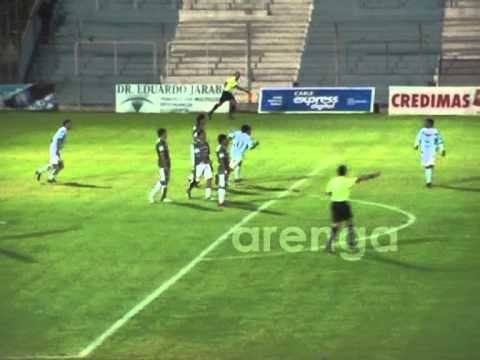

In [9]:
def show_yt8m(short_id, labels=None):
    """Show video with labels"""
    if labels is not None:
        print('label names of this video:',\
          [label_mapping[x] for x in labels])
    vid = get_youtube_id(short_id)
    return YouTubeVideo(vid)


show_yt8m(short_id='0Ebs')

label names of this video: ['Car', 'Musical ensemble']
gfeTSrI_n38


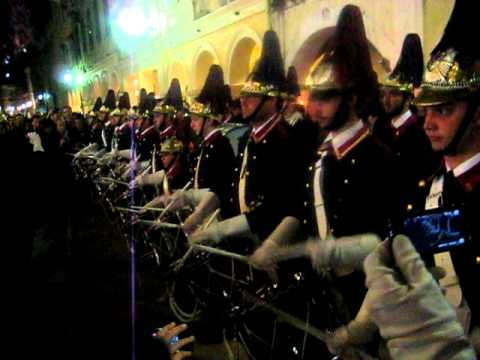

In [10]:
show_yt8m(short_id='2caz',labels=[4, 13])

## Task 2: Defining your logistic model (15 points)
Complete the model definition below to define a simple logistic regression model

In [54]:
class LogisticRegressionModel(nn.Module):
    def __init__(self):
        super(LogisticRegressionModel, self).__init__()
        # TODO: complete the layers below
        self.fc = nn.Linear(feat_dim,nb_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        x = self.fc(x)
        x = self.sigmoid(x)
        #x = self.sigmoid(self.fc(x))
        return x
    

In [55]:
device = 'cuda'
# device = 'cpu'
#TODO: create an instance of your model
        ################################ TODO ##################################
model = LogisticRegressionModel()
        ################################ TODO ##################################
model = model.to(device)
summary(model, input_size = (feat_dim,))
#model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 3862]       3,958,550
           Sigmoid-2                 [-1, 3862]               0
Total params: 3,958,550
Trainable params: 3,958,550
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 15.10
Estimated Total Size (MB): 15.16
----------------------------------------------------------------


## Task 3: Training (20 points)
Complete the code below to train your logisitc regression model

In [56]:
def validate(model, dataloader, loss, mode = 'Validation', thresh = 0.5, save_path='saved_weight_video.pth'):
    #TODO: put the model in the evaluation mode
        ################################ TODO ##################################
    model.eval()
    running_correct = 0
    running_positive = 0
    running_val_loss = 0
    num_samp = len(dataloader)
    with torch.no_grad():
        for i, sample in enumerate(dataloader):
            preds = model(sample['video'].float().to(device))
            #TODO: threshold the predictions of the Sigmoid activation to obtain positive predictions  
                    ################################ TODO ##################################
            positive_preds = torch.where(preds>thresh,torch.zeros_like(preds),torch.ones_like(preds))
                    ################################ TODO ##################################
            gt_labels = sample['label'].to(device)
            correct_preds = (positive_preds == (gt_labels > 0))
            running_correct = running_correct + torch.sum(correct_preds & (gt_labels > 0)) 
            running_positive = running_positive + torch.sum(preds)  
            #TODO: calculate the loss
                    ################################ TODO ##################################
            loss_val = loss(preds,gt_labels)
                    ################################ TODO ##################################
            running_val_loss = running_val_loss + loss_val.detach() 
        precision = running_correct / running_positive
        print(f'Loss for {mode}: {running_val_loss / num_samp}, Precision for {mode}: {precision}')
    return running_val_loss / num_samp

In [64]:
loss_train_arr = []
loss_val_arr = []
def train(model, dataloader, optimizer, loss, epochs = 1, device = 'cpu', thresh = 0.5, save_path='saved_weight_video.pth'):
    for e in range(epochs):
        #TODO: set the model to the training mode
                ################################ TODO ##################################
        model.train()
        running_train_loss = 0
        running_correct = 0
        running_positive = 0
        num_samp = len(dataloader)
        for i, sample in enumerate(dataloader):
            optimizer.zero_grad()
            preds = model(sample['video'].float().to(device))
            #TODO: threshold the predictions of the Sigmoid activation to obtain positive predictions
                    ################################ TODO ##################################
            positive_preds = torch.where(preds>thresh,torch.zeros_like(preds),torch.ones_like(preds))
                    ################################ TODO ##################################
            gt_labels = sample['label'].to(device)
            correct_preds = (positive_preds == (gt_labels > 0))
            running_correct = running_correct + torch.sum(correct_preds & (gt_labels > 0)) 
            running_positive = running_positive + torch.sum(preds) 
            #TODO: calculate the loss 
                    ################################ TODO ##################################
            loss_train = loss(preds,gt_labels)
                    ################################ TODO ##################################
            loss_train.backward()
            #TODO: do the optimization step
            optimizer.step()
            running_train_loss = running_train_loss + loss_train.detach() 

        loss_train_arr.append(running_train_loss / num_samp)
        precision = running_correct / running_positive
        print(f'Epoch: {e + 1}')
        print(f'Loss: {running_train_loss / num_samp}, Precision: {precision}')
        torch.save(model.state_dict(), save_path)
        loss_validate = validate(model, dataloader_validate, loss)
        loss_val_arr.append(loss_validate)
        print()

In [71]:

#TODO: choose the learning rate and number of epochs to be trained
################################ TODO ##################################
lr = 1e-4
epochs = 70
################################ TODO ##################################
optimizer = optim.Adam(model.parameters(), lr = lr)
loss = nn.BCEWithLogitsLoss()
loss = loss.to(device)
train(model, dataloader_train, optimizer, loss, device=device, epochs=epochs)

Epoch: 1
Loss: 0.6940691471099854, Precision: 0.2045619636774063
Loss for Validation: 0.6939466595649719, Precision for Validation: 0.2326052337884903

Epoch: 2
Loss: 0.6937928199768066, Precision: 0.26251375675201416
Loss for Validation: 0.6937128305435181, Precision for Validation: 0.2952740490436554

Epoch: 3
Loss: 0.6936036944389343, Precision: 0.32830747961997986
Loss for Validation: 0.6935453414916992, Precision for Validation: 0.3673376142978668

Epoch: 4
Loss: 0.6934540867805481, Precision: 0.4023238718509674
Loss for Validation: 0.693423330783844, Precision for Validation: 0.4454553723335266

Epoch: 5
Loss: 0.6933616399765015, Precision: 0.47953230142593384
Loss for Validation: 0.6933349370956421, Precision for Validation: 0.5270807147026062

Epoch: 6
Loss: 0.693284809589386, Precision: 0.5590334534645081
Loss for Validation: 0.6932709813117981, Precision for Validation: 0.6067166924476624

Epoch: 7
Loss: 0.6932219862937927, Precision: 0.6335116028785706
Loss for Validation: 0

## Plotting the training and validation losses

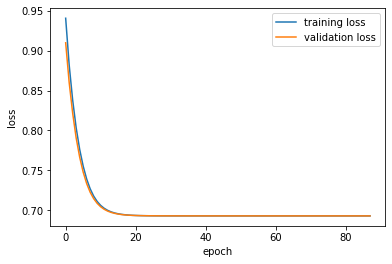

In [72]:
plt.plot(loss_train_arr, label = 'training loss')
plt.plot(loss_val_arr, label = 'validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

## Task 4: Testing the model performance (15 points)
By choosing the apporpriate number of epochs and learning rate (Hyperparameters), train your model to get at least **70%** accuracy on the test set/


In [73]:
#TODO: reach the requred accuracy on the test set
        ################################ TODO ##################################
loss_test = validate(model, dataloader_test, loss)

Loss for Validation: 0.6930686235427856, Precision for Validation: 1.0107762813568115


In [61]:
sample = dataset_test[40]
print(sample)
labels = np.nonzero(sample['label'])
id = sample['id']
print(labels.squeeze())

{'video': tensor([ 0.5172, -0.0255,  1.7697,  ..., -0.2402, -0.0147, -0.5956],
       dtype=torch.float64), 'label': tensor([0., 0., 0.,  ..., 0., 0., 0.]), 'id': '0Adv'}
tensor([3, 4, 6])


label names of this video: ['Concert', 'Car', 'Animation']
BR_bCb_F37o


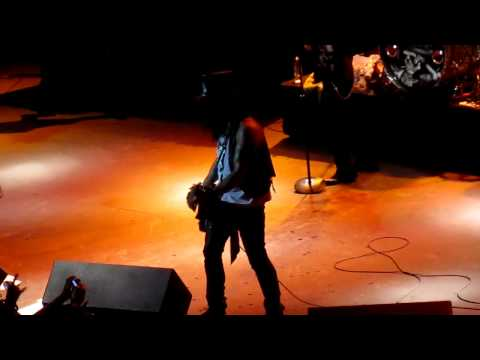

In [62]:
show_yt8m(short_id=id,labels=labels.squeeze().numpy())

In [63]:
preds = model(dataset_test[40]['video'].float().to(device))
print(np.nonzero(preds > 0.5))

tensor([[   2],
        [   7],
        [   8],
        ...,
        [3854],
        [3856],
        [3859]], device='cuda:0')
